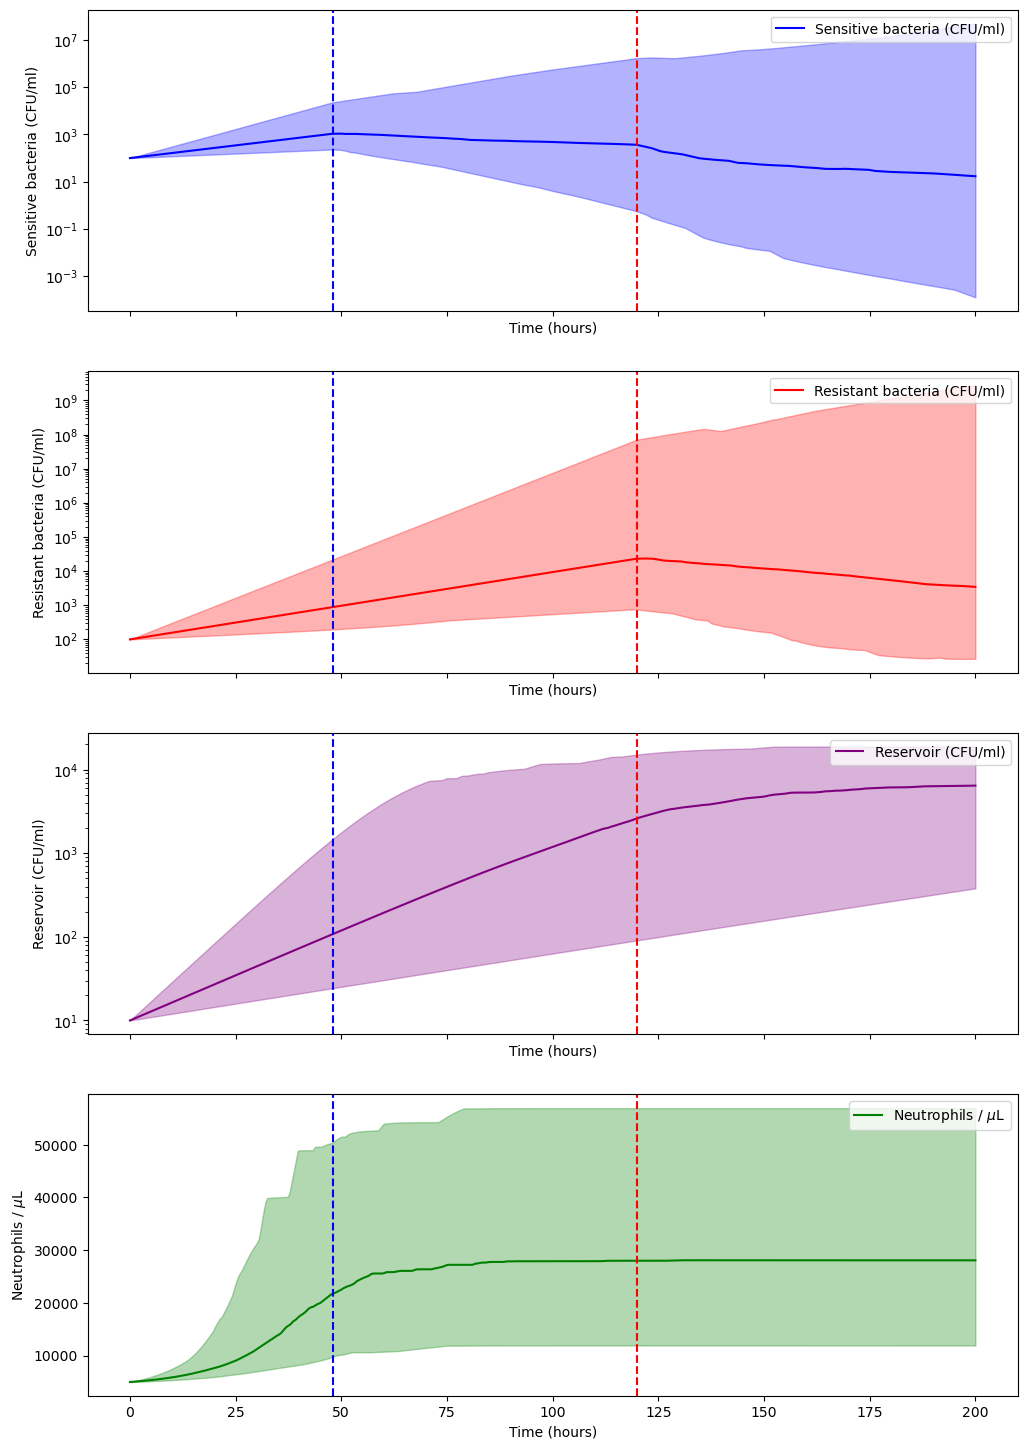

In [17]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# --- Pharmacokinetic Model (same as before) ---
class PharmacokineticModel:
    def __init__(self):
        self.van_dose = 1000
        self.van_interval = 6
        self.van_duration = 72
        self.van_ke = 0.173
        self.van_volume = 50

        self.lzd_dose = 600
        self.lzd_interval = 12
        self.lzd_duration = 192
        self.lzd_ke = 0.116
        self.lzd_volume = 45

    def calculate_concentrations(self, drug_type, total_sim_time_h, start_time_h=0):
        if drug_type == 'vancomycin':
            dose, interval, duration, ke, volume = self.van_dose, self.van_interval, self.van_duration, self.van_ke, self.van_volume
        else:
            dose, interval, duration, ke, volume = self.lzd_dose, self.lzd_interval, self.lzd_duration, self.lzd_ke, self.lzd_volume

        t = np.linspace(0, total_sim_time_h, int(total_sim_time_h * 10) + 1)
        concentrations = np.zeros_like(t)
        end_drug_time = start_time_h + duration

        for dose_time in np.arange(start_time_h, end_drug_time, interval):
            dose_mask = t >= dose_time
            concentrations[dose_mask] += (dose / volume) * np.exp(-ke * (t[dose_mask] - dose_time))

        concentrations[t < start_time_h] = 0.0
        return t, concentrations


# --- Immune & PD ODE system (same as before) ---
def immune_and_pd_model(y, t_days, params, van_interp, lzd_interp):
    S, R, A_res, N = y
    t_hours = t_days * 24
    V = max(0, van_interp(t_hours))
    L = max(0, lzd_interp(t_hours))

    S, R, A_res, N = max(S, 0), max(R, 0), max(A_res, 0), max(N, 0)
    B_total = S + R


    h_V = 1.0#hill params both vanco and linezolid removed from params dict and set to constant value
    h_L = 1.0
    
    linezolid_inhibition = (params['Emax_l'] * (L**h_L)) / ((params['EC50_l']**h_L) + (L**h_L))
    vancomycin_kill_rate = (params['Emax_v'] * (V**h_V)) / ((params['EC50_v']**h_V) + (V**h_V))

    logistic_factor = (1 - B_total / params['B_max'])
    immune_kill_S = params['kill_N'] * N * S
    immune_kill_R = params['kill_N'] * N * R

    dSdt = (params['rho_S'] * S * logistic_factor) - (params['delta'] * S) - immune_kill_S - (vancomycin_kill_rate * S) - (linezolid_inhibition * S)
    dRdt = (params['rho_R'] * R * logistic_factor) - (params['delta'] * R) - (linezolid_inhibition * R) - immune_kill_R + (params['f_r_b'] * A_res) - (params['f_b_r'] * R)

    reservoir_growth = params['rho_res'] * A_res * (1 - A_res / params['k_res'])
    dA_res_dt = reservoir_growth - (params['delta_res'] * A_res) - (params['f_r_b'] * A_res) - params['kill_N'] * N * A_res                                                                                                           

    dNdt = params['rho_N'] * N * (B_total) * (1 - N / params['N_MAX']) - params['delta_N'] * N
    return [dSdt, dRdt, dA_res_dt, dNdt]


# --- Base parameters ---
base_params = {
    'rho_S': 1.47, 'rho_R': 1.47, 'B_max': 4e12, 'delta': 0.179,
    'kill_N': 1e-7, 'rho_N': 2e-3, 'N_MAX': 30000, 'delta_N': 0.003,
    'Emax_v': 1.74, 'Emax_l': 1.97, 'EC50_v': 0.245, 'EC50_l': 0.56,
    'rho_res': 1.47, 'k_res': 1e4, 'delta_res': 0.179,
    'f_r_b': 0.02, 'f_b_r': 0.02
}
#model parmaeters from Model-based translation of the PKPD-relationship 
#for linezolid and vancomycin on methicillin-resistant Staphylococcus aureus: from invitro time-kiill experiements to a mouse penumonia model
#Journal Antimicrob Chemother 2025: 80 1860-1968.

# --- Monte Carlo sampling ---
"""
base params is a dict containing base values. for each param the code samples from a log normal distribution centered on 
mean_val with a spread of sigma. Each simulation runs slightly different values of each parameter -> uncertainity/variability
modeling
"""
def sample_parameters(base_params, sigma=0.3):
    sampled_params = {}
    for key, mean_val in base_params.items():
        mu = np.log(mean_val) - 0.5 * sigma**2
        sampled_params[key] = np.random.lognormal(mean=mu, sigma=sigma)
    return sampled_params


def run_mc_with_stats(n_iter=100, sigma=0.4):
    total_sim_time_h = 200.0
    pk_model = PharmacokineticModel()

    vanco_start_h = 48.0
    linezolid_start_h = vanco_start_h + pk_model.van_duration

    t_van_h, conc_van = pk_model.calculate_concentrations('vancomycin', total_sim_time_h, start_time_h=vanco_start_h)
    t_lzd_h, conc_lzd = pk_model.calculate_concentrations('linezolid', total_sim_time_h, start_time_h=linezolid_start_h)

    van_func = interp1d(t_van_h, conc_van, bounds_error=False, fill_value=0)
    lzd_func = interp1d(t_lzd_h, conc_lzd, bounds_error=False, fill_value=0)

    t_days = np.linspace(0, total_sim_time_h / 24.0, 500)
    y0 = [1e2, 1e2, 1e1, 5000]#initial conditions

    all_results = []
    for i in range(n_iter):
        sampled_params = sample_parameters(base_params, sigma=sigma)
        sol = odeint(immune_and_pd_model, y0, t_days, args=(sampled_params, van_func, lzd_func))
        all_results.append(sol)

    return t_days, np.stack(all_results, axis=0)

#t_vanco_start = 48
#t_linex_start = t_vanco_start + 72

def plot_with_intervals(ax, t_days, results, var_index, label, color,
                        t_vanco_start, t_linez_start, logy=True,
                        show_drug_labels=False):
    data = results[:,:,var_index]
    median = np.percentile(data, 50, axis=0)
    low = np.percentile(data, 2.5, axis=0)
    high = np.percentile(data, 97.5, axis=0)

    ax.plot(t_days*24, median, color=color, label=label)
    ax.fill_between(t_days*24, low, high, color=color, alpha=0.3)
    
    # Only show drug start labels if specified
    if show_drug_labels:
        ax.axvline(x=t_vanco_start, color="blue", linestyle="--", label="Vancomycin start")
        ax.axvline(x=t_linez_start, color="red", linestyle="--", label="Linezolid start")
    else:
        ax.axvline(x=t_vanco_start, color="blue", linestyle="--", label="_nolegend_")
        ax.axvline(x=t_linez_start, color="red", linestyle="--", label="_nolegend_")
    
    ax.set_xlabel("Time (hours)")
    ax.set_ylabel(label)
    if logy:
        ax.set_yscale("log")
    ax.legend()




# --- Run Monte Carlo and Plot ---

t_vanco_start = 48                  # Vancomycin start time in hours
t_linez_start = t_vanco_start + 72  # Linezolid starts after Vancomycin ends

t_days, mc_results = run_mc_with_stats(n_iter=200, sigma=0.4)

fig, axes = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

plot_with_intervals(axes[0], t_days, mc_results, 0, "Sensitive bacteria (CFU/ml)", "blue",
                    t_vanco_start, t_linez_start, logy=True)
plot_with_intervals(axes[1], t_days, mc_results, 1, "Resistant bacteria (CFU/ml)", "red",
                    t_vanco_start, t_linez_start, logy=True)
plot_with_intervals(axes[2], t_days, mc_results, 2, "Reservoir (CFU/ml)", "purple",
                    t_vanco_start, t_linez_start, logy=True)
plot_with_intervals(axes[3], t_days, mc_results, 3, r'Neutrophils / $\mu$L', "green",
                    t_vanco_start, t_linez_start, logy=False)


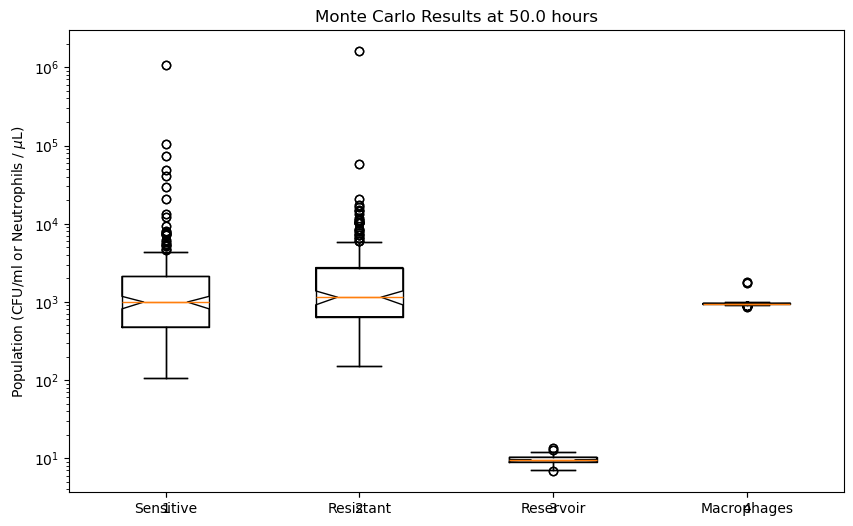

In [9]:
t_target_h = 50.0
t_target_day = t_target_h / 24.0

idx = np.argmin(np.abs(t_days - t_target_day))
sensitive = mc_results[:, idx, 0]
resistant = mc_results[:, idx, 1]
reservoir = mc_results[:, idx, 2]
macrophages = mc_results[:, idx, 3]

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

data = [sensitive, resistant, reservoir, macrophages]
labels = ["Sensitive", "Resistant", "Reservoir", "Neutrophils"]

plt.figure(figsize=(10,6))
plt.boxplot(data, plt.boxplot(data, labels=labels, showfliers=True))
plt.ylabel(r"Population (CFU/ml or Neutrophils / $\mu$L)")
plt.title(f"Monte Carlo Results at {t_target_h} hours")
plt.yscale("log")  # optional, since bacterial populations can vary a lot
plt.show()




---

### 🔹 Table: Recommended Monte Carlo Statistics for Bacterial/Immune Model

| Variable                     | Single-Time Summary (e.g., 150 h)                                                             | Time-Series Summary (all t)                                                        | Notes / Usage                                                      |
| ---------------------------- | --------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- | ------------------------------------------------------------------ |
| Sensitive bacteria (`S`)     | Median, Mean, SD, 2.5–97.5% CI, Min/Max, IQR, Fraction exceeding threshold (e.g., 10⁶ CFU/ml) | Median ± 95% CI over time, Time to peak, Time below detection limit                | Use log scale for visualization due to wide range of CFU/ml        |
| Resistant bacteria (`R`)     | Median, Mean, SD, 2.5–97.5% CI, Min/Max, IQR, Fraction exceeding threshold (e.g., 10⁶ CFU/ml) | Median ± 95% CI over time, Time to peak, Fraction of runs where resistance emerges | Important for evaluating drug sequencing and therapy effectiveness |
| Reservoir bacteria (`A_res`) | Median, Mean, SD, 2.5–97.5% CI, Min/Max, IQR                                                  | Median ± 95% CI over time, Maximum reservoir size, Fraction seeding bloodstream    | Reservoir often small; log scale useful                            |
| Macrophages (`M`)            | Median, Mean, SD, 2.5–97.5% CI, Min/Max, IQR                                                  | Median ± 95% CI over time, Time to immune peak, Fraction below baseline            | Usually linear scale; can track immune suppression or overshoot    |

---

### 🔹 Suggested Python Implementation

**Single time point (150 h) statistics:**

```python
import numpy as np

t_target_h = 150
t_target_day = t_target_h / 24
idx = np.argmin(np.abs(t_days - t_target_day))

variables = ["Sensitive", "Resistant", "Reservoir", "Macrophages"]
summary_table = {}

for i, var in enumerate(variables):
    data = mc_results[:, idx, i]
    summary_table[var] = {
        "Mean": np.mean(data),
        "Median": np.median(data),
        "SD": np.std(data),
        "2.5%": np.percentile(data, 2.5),
        "97.5%": np.percentile(data, 97.5),
        "Min": np.min(data),
        "Max": np.max(data),
        "IQR": np.percentile(data, 75) - np.percentile(data, 25)
    }

import pandas as pd
df_summary = pd.DataFrame(summary_table).T
print(df_summary)
```

---

**Time-series statistics (for plotting median ± 95% CI):**

```python
time_series_stats = {}
for i, var in enumerate(variables):
    data = mc_results[:, :, i]  # shape: (n_iter, n_timepoints)
    median = np.percentile(data, 50, axis=0)
    lower = np.percentile(data, 2.5, axis=0)
    upper = np.percentile(data, 97.5, axis=0)
    time_series_stats[var] = {"median": median, "lower": lower, "upper": upper}
```

This gives you everything needed for **boxplots at specific times**, **uncertainty bands over time**, and **threshold probabilities**.

---



In [30]:
import numpy as np

t_target_h = 150
t_target_day = t_target_h / 24
idx = np.argmin(np.abs(t_days - t_target_day))

variables = ["Sensitive", "Resistant", "Reservoir", "Macrophages"]
summary_table = {}

for i, var in enumerate(variables):
    data = mc_results[:, idx, i]
    summary_table[var] = {
        "Mean": np.mean(data),
        "Median": np.median(data),
        "SD": np.std(data),
        "2.5%": np.percentile(data, 2.5),
        "97.5%": np.percentile(data, 97.5),
        "Min": np.min(data),
        "Max": np.max(data),
        "IQR": np.percentile(data, 75) - np.percentile(data, 25)
    }

import pandas as pd
df_summary = pd.DataFrame(summary_table).T
print(df_summary)


                      Mean       Median             SD          2.5%  \
Sensitive     41860.718884     0.001097  217420.121618  8.666279e-17   
Resistant    260684.878402  7960.756491  709379.498786  6.562338e-01   
Reservoir       433.050172   426.423299     173.949953  1.995377e+02   
Macrophages     105.615735    99.743797      23.314117  7.830068e+01   

                    97.5%           Min           Max            IQR  
Sensitive    7.117136e+05 -1.721204e-11  2.201088e+06       9.052319  
Resistant    2.228215e+06  2.758927e-01  5.938171e+06  130226.574775  
Reservoir    7.349460e+02  1.112399e+02  2.146521e+03     152.563107  
Macrophages  1.730071e+02  7.142549e+01  2.529822e+02      20.501981  


In [34]:
import numpy as np
import pandas as pd

def summarize_mc(mc_results, t_days, time_points_h, threshold_dict=None):
    """
    Summarize Monte Carlo results for multiple time points.

    Parameters
    ----------
    mc_results : np.ndarray
        Monte Carlo results array of shape (n_iter, n_timepoints, n_variables)
    t_days : np.ndarray
        Time vector in days (length n_timepoints)
    time_points_h : list
        List of times (in hours) at which to summarize results
    threshold_dict : dict, optional
        Dictionary specifying thresholds for variables, e.g.,
        {"Sensitive": 1e6, "Resistant": 1e6}

    Returns
    -------
    None, prints formatted summary tables
    """
    variables = ["Sensitive", "Resistant", "Reservoir", "Macrophages"]
    
    for t_h in time_points_h:
        t_day = t_h / 24.0
        idx = np.argmin(np.abs(t_days - t_day))
        print(f"\n=== Monte Carlo Summary at {t_h} hours ===")
        
        summary_table = {}
        for i, var in enumerate(variables):
            data = mc_results[:, idx, i]
            summary_table[var] = {
                "Mean": np.mean(data),
                "Median": np.median(data),
                "SD": np.std(data),
                "2.5%": np.percentile(data, 2.5),
                "97.5%": np.percentile(data, 97.5),
                "Min": np.min(data),
                "Max": np.max(data),
                "IQR": np.percentile(data, 75) - np.percentile(data, 25)
            }
            
            # Fraction above threshold (if specified)
            if threshold_dict and var in threshold_dict:
                thresh = threshold_dict[var]
                frac = np.sum(data > thresh) / len(data)
                summary_table[var]["Frac > " + str(thresh)] = frac
        
        # Convert to DataFrame for nice printing
        df_summary = pd.DataFrame(summary_table).T
        print(df_summary.round(3))


# --- Example Usage ---
# Assume mc_results shape: (n_iter, n_timepoints, 4)
# t_days shape: (n_timepoints,)
# Summarize at 150 hours, with threshold 1e6 CFU/ml for bacteria

thresholds = {"Sensitive": 1e6, "Resistant": 1e6}
summarize_mc(mc_results, t_days, time_points_h=[150], threshold_dict=thresholds)



=== Monte Carlo Summary at 150 hours ===
                   Mean    Median          SD     2.5%        97.5%      Min  \
Sensitive     41860.719     0.001  217420.122    0.000   711713.576   -0.000   
Resistant    260684.878  7960.756  709379.499    0.656  2228214.663    0.276   
Reservoir       433.050   426.423     173.950  199.538      734.946  111.240   
Macrophages     105.616    99.744      23.314   78.301      173.007   71.425   

                     Max         IQR  Frac > 1000000.0  
Sensitive    2201088.197       9.052              0.01  
Resistant    5938170.623  130226.575              0.07  
Reservoir       2146.521     152.563               NaN  
Macrophages      252.982      20.502               NaN  


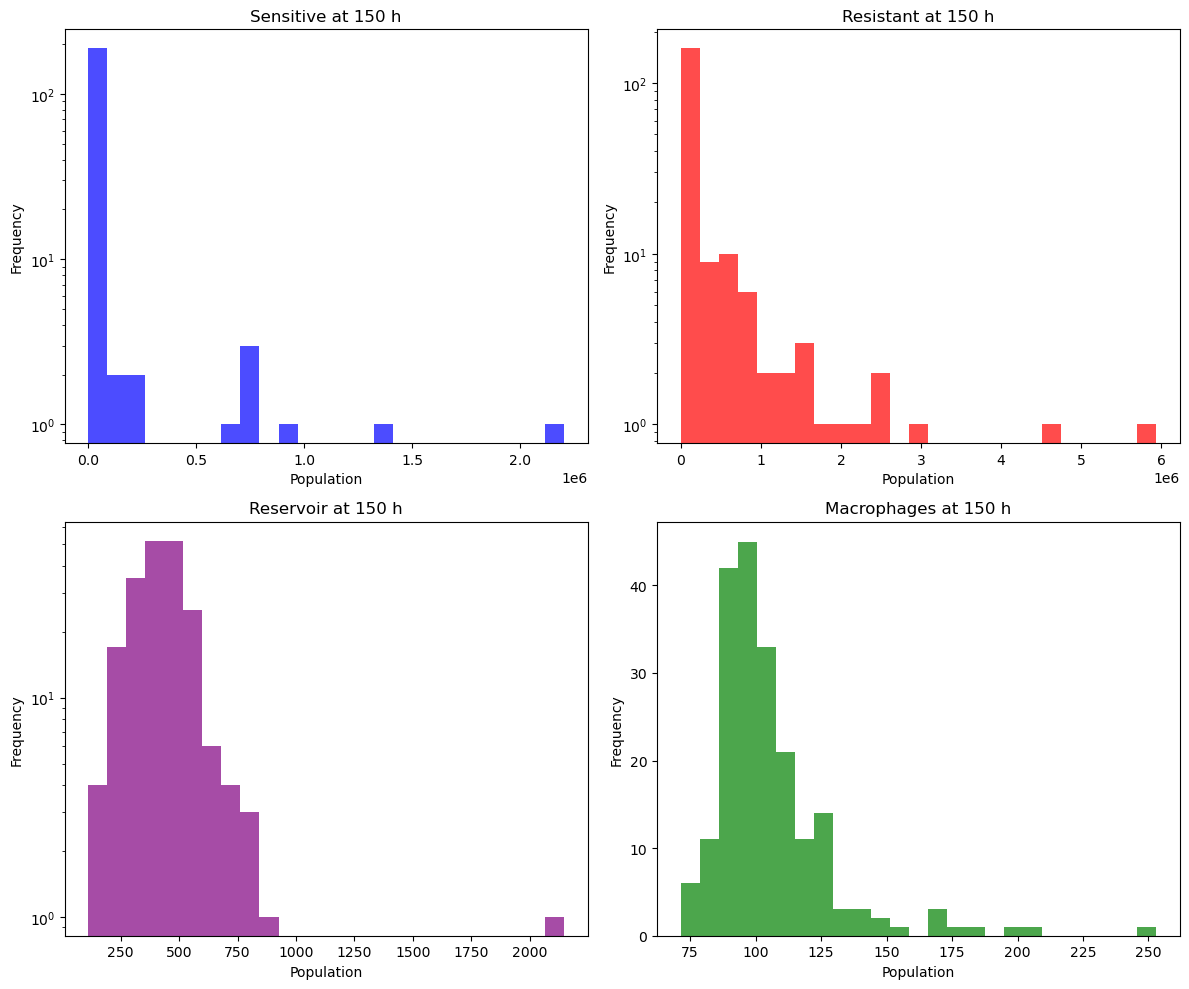

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# --- Convert target time to index ---
t_target_h = 150
t_target_day = t_target_h / 24.0
idx = np.argmin(np.abs(t_days - t_target_day))

# --- Extract data at 150 hours ---
sensitive = mc_results[:, idx, 0]
resistant = mc_results[:, idx, 1]
reservoir = mc_results[:, idx, 2]
macrophages = mc_results[:, idx, 3]

data_list = [sensitive, resistant, reservoir, macrophages]
labels = ["Sensitive", "Resistant", "Reservoir", "Macrophages"]
colors = ["blue", "red", "purple", "green"]

# --- Plot histograms ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(data_list[i], bins=25, color=colors[i], alpha=0.7)
    ax.set_title(f"{labels[i]} at {t_target_h} h")
    
    # Set y-axis scale
    if labels[i] != "Macrophages":
        ax.set_yscale("log")  # Bacterial populations often vary over orders of magnitude
    
    ax.set_xlabel("Population")
    ax.set_ylabel("Frequency")
    
plt.tight_layout()
plt.show()


When analyzing Monte Carlo simulations, the goal is usually to summarize the distribution of outputs across many runs, quantify uncertainty, and sometimes check convergence or sensitivity. Here are the most common statistics and techniques:

1. Central Tendency

Mean: The average value across all Monte Carlo iterations.

Gives a “typical” expected outcome.

Example: np.mean(results_array, axis=0)

Median: The 50th percentile.

Less sensitive to outliers than the mean.

Often used in biological simulations with skewed distributions.

2. Dispersion / Uncertainty

Standard deviation (SD): Measures spread of outcomes around the mean.

Variance: SD squared.

Percentiles / Quantiles: e.g., 2.5th and 97.5th percentiles to form a 95% confidence interval (CI).

Very common for plotting uncertainty bands in time series.

Example:

lower = np.percentile(results_array, 2.5, axis=0)
upper = np.percentile(results_array, 97.5, axis=0)

3. Range / Extreme values

Minimum / Maximum: Useful to check if there are rare extreme behaviors.

Interquartile range (IQR): Difference between 75th and 25th percentiles; robust measure of spread.

4. Probability of Threshold Exceedance

Count how many Monte Carlo runs exceed a critical value.

Example: Probability bacterial population exceeds 
10
6
10
6
 CFU/ml at 150 hours.

Often expressed as a fraction or percentage.

5. Correlation / Sensitivity

Correlation coefficients between inputs and outputs (Pearson, Spearman) can highlight which parameters drive variability.

Variance-based sensitivity indices (Sobol, FAST) quantify contributions of input uncertainty to output variance.

6. Convergence Checks

Running mean / variance plots to see if adding more Monte Carlo iterations stabilizes the estimates.

Coefficient of variation (CV): SD / mean — low CV indicates stable estimate.

7. Visual Summaries

Histograms: Show full distribution of outcomes at a single time point.

Boxplots / Violin plots: Summarize median, quartiles, and outliers.

Time series bands: Median ± 95% CI for simulations over time (like you’re plotting for S, R, M, reservoir).

Program notes: 

Why you see different sigmas

It looks like the code was written to allow flexibility:

sample_parameters(..., sigma=0.3) → maybe used for a default or “tighter” variation.

run_mc_with_stats(..., sigma=0.4) → passes a slightly larger value when running Monte Carlo, so you get more biological variability in the simulations.

But notice: if run_mc_with_stats calls sample_parameters, the sigma you pass to run_mc_with_stats is what actually controls it — the 0.3 in the sample_parameters definition is just a default, only used if you don’t supply one.

✅ So in practice:

If you call run_mc_with_stats(n_iter=100), it uses sigma=0.4.

If you directly call sample_parameters(base_params), it uses sigma=0.3 (unless you override).

Perfect — let’s unpack exactly what this line is doing:

```python
np.stack(all_results, axis=0)
```

---

### 🔹 What `all_results` looks like

In your Monte Carlo loop, each simulation produces a result (like time series values for sensitive bacteria, resistant bacteria, macrophages, etc.).
So after running `n_iter` simulations, you have something like:

```python
all_results = [
    result_from_run1,   # maybe shape (len(t), 4)
    result_from_run2,   # same shape
    result_from_run3,
    ...
]
```

So `all_results` is basically a **list of arrays**, each of the same shape.

---

### 🔹 What `np.stack` does

`np.stack` takes that list of arrays and makes one big array with a new axis.

For example:

```python
a = np.array([1,2,3])
b = np.array([4,5,6])
all_results = [a, b]
np.stack(all_results, axis=0)
```

Result:

```
array([[1, 2, 3],
       [4, 5, 6]])
```

Here:

* `a` was shape `(3,)`
* `b` was shape `(3,)`
* After stacking → shape `(2, 3)`

So the **new first axis indexes the Monte Carlo runs**, and the later axes are whatever data each run contained.

---

### 🔹 In your case

If each run returns a trajectory array shaped `(len(t), 4)` (say 1001 time points × 4 variables), then after stacking:

```python
results_array = np.stack(all_results, axis=0)
```

* Shape = `(n_iter, len(t), 4)`
* Example = `(100, 1001, 4)` if you did 100 runs with 1001 time points.

So now you can easily compute statistics across simulations, e.g.:

```python
np.mean(results_array, axis=0)   # average trajectory across runs
np.percentile(results_array, 5, axis=0)   # 5th percentile
```

---

✅ **Summary:**
`np.stack(all_results, axis=0)` takes your list of simulation results and builds one big 3D array where:

* **axis 0** = simulation index (Monte Carlo run)
* **axis 1** = time points
* **axis 2** = variables (S, R, reservoir, M, etc.)

---

Do you want me to show you a **small toy example with your S, R, M setup** so you can see the shape before and after `np.stack`?


Great idea 👍 — let’s build a small **toy example** with sensitive bacteria (S), resistant bacteria (R), reservoir (Res), and macrophages (M).

Suppose we simulate **3 runs** (Monte Carlo iterations), each over **5 time points**.

---

### 🔹 Step 1. Imagine each run returns a `(time, variables)` array

Each run outputs `[S, R, Res, M]` at each time point.

For **run 1**:

```
[[1, 2, 3, 4],   # t0
 [2, 3, 4, 5],   # t1
 [3, 4, 5, 6],   # t2
 [4, 5, 6, 7],   # t3
 [5, 6, 7, 8]]   # t4
```

For **run 2**:

```
[[10,11,12,13],
 [11,12,13,14],
 [12,13,14,15],
 [13,14,15,16],
 [14,15,16,17]]
```

For **run 3**:

```
[[20,21,22,23],
 [21,22,23,24],
 [22,23,24,25],
 [23,24,25,26],
 [24,25,26,27]]
```

So each run’s result has **shape `(5,4)`** (5 time points × 4 variables).

---

### 🔹 Step 2. Put them into a list

```python
import numpy as np

run1 = np.array([[1,2,3,4],
                 [2,3,4,5],
                 [3,4,5,6],
                 [4,5,6,7],
                 [5,6,7,8]])

run2 = np.array([[10,11,12,13],
                 [11,12,13,14],
                 [12,13,14,15],
                 [13,14,15,16],
                 [14,15,16,17]])

run3 = np.array([[20,21,22,23],
                 [21,22,23,24],
                 [22,23,24,25],
                 [23,24,25,26],
                 [24,25,26,27]])

all_results = [run1, run2, run3]
```

---

### 🔹 Step 3. Stack them

```python
stacked = np.stack(all_results, axis=0)
print(stacked.shape)
```

Output:

```
(3, 5, 4)
```

* **axis 0** = run index (3 runs)
* **axis 1** = time (5 steps)
* **axis 2** = variables (S, R, Res, M → 4 variables)

---

### 🔹 Step 4. Access and analyze

* `stacked[0]` → run 1 data (shape `(5,4)`)
* `stacked[:, :, 0]` → all runs, all times, **only S (sensitive bacteria)**
* `np.mean(stacked, axis=0)` → average across runs, shape `(5,4)`

---

✅ So this is exactly what’s happening in your Monte Carlo code:
The stack turns a *list of runs* into a **3D array**, making it easy to compute averages and percentiles across runs.

---

Do you want me to extend this toy example to also show how you’d plot **S, R, Res, M on separate graphs with uncertainty bands** (like mean ± percentile across runs)?
